We want to train a motion prediction model, which takes the 6D-pose of an object(in our case a robot) and it's velocity(linear, angular), and uses this information to predict the position of the object a few seconds ahead. So the model observes, e.g. the last 10 seconds of a movement and creates a prediction based on this time window. The prediction is one timestep, so 1 second, which is the timestep that comes after the last 10 seconds.

# The LSTM
The model we chose to use for our project is the LSTM. The LSTM is a model able to capture long-term dependencies, as the name suggest (Long-Short Term Memory), making it ideal for sequence prediction and, in our case, motion forecasting. \
The principle of the LSTM is to deal with the vanishing / exploding gradient problem of RNNs by saving the long-term memory and the short-term memory into two different states; the long-term memory is saved in the cell state (c_t), while the short-term memory is saved in the hidden state (h_t).
![alt text](LSTM.png)

## The LSTM cell
The LSTM cell is called a "gated structure"; this is beacuse each cell has three gates, called the forget gate, the input gate and the output gate
![alt text](LSTM_Cell.png)

### The forget gate
The forget gate controls how much of the long-term memory we keep by passing the current input through a sigmoid function together with the hidden layer and bias, and then multiplying it by the previous cell state c_t-1. A smaller value means less relevance of the past memory, while a bigger value means more relevance. In other words, the forget gate decides what to delete from the past
![alt text](ForgetGate.png)

### The input gate
The input gate decides how much of the current input and hidden state will influence the future long-term memory; in other words, decides what to add to the memory from the present.
![alt text](InputGate.png)

### The output gate
The output gate takes the updated cell state (C_t), applies a tanh⁡ function to scale its values between −1 and 1, and then multiplies this by o_t (the output gate's activation vector). This produces the hidden state. The hidden state (h_t) represents the short-term memory that is immediately relevant for making predictions or decisions at the current time step. \
In other words, the output gate decides how much of the current memory should be shared as hidden state.
![alt text](OutputGate.png)

# The model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import math
import wandb
import os

import json
import pandas as pd

In [5]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz

        # Projection layer to adjust input to hidden size to handle any input size
        self.input_projection = nn.Linear(input_sz, hidden_sz)

        self.W = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4)) # Input weights: [U_i, U_o, U_c, U_f]
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4)) # Hidden state weights: [W_i, W_o, W_c, W_f]
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4)) # Biases: [b_i, b_o, b_c, b_f]
        self.init_weights()

        # FUlly connected layer to original input size for making predictions 
        self.fc = nn.Linear(hidden_sz, input_sz)

    def forward(self, x, init_states=None):
        bs, seq_sz, input_features = x.size() # Unpack x to batch size, sequence size (time steps), input features

        # Project input to hidden size
        x_projected = self.input_projection(x)

        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size 
        for t in range(seq_sz): # For each time step t:
            x_t = x_projected[:, t, :] # We take the curret input
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))

        # Use the last hidden state for prediction
        prediction = self.fc(h_t)

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return prediction, (h_t, c_t)

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

# Training and validation loop

In [6]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AMPM",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.005,
    "architecture": "LSTM",
    "dataset": "Self-collected, dataset6",
    "epochs": 110,
    "hidden_size": 64,
    "normalization": "Standardized",
    "batch_size": 32
    }
)

wandb: Currently logged in as: samueleghizzo (samueleghizzo-university-of-klagenfurt). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Merge `num_windows` with `batch_size`
            bs, nw, seq_len, feature_dim = X_batch.shape
            # print("X_batch shape before merging: ", X_batch.shape)
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)
            # print("X_batch shape after merging: ", X_batch.shape)

            # Adjust y_batch accordingly
            y_batch = y_batch.view(bs * nw, -1)

            # Pass reshaped inputs to the model
            output, _ = model(X_batch)

            # Compute the loss
            loss = criterion(output, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        wandb.log({"Train loss": train_loss})
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
               
                bs, nw, seq_len, feature_dim = X_batch.shape
                X_batch = X_batch.view(bs * nw, seq_len, feature_dim)

                y_batch = y_batch.view(bs * nw, -1)

                output, _ = model(X_batch)
               
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Apply scheduler step to reduce learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        wandb.log({"Val loss": val_loss})

    return train_losses, val_losses

# Dataset creation

In [ ]:
'''
import pandas as pd
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data(filepath):
    tensor_files = [os.path.join(root, file) for root, dirs, files in os.walk(filepath) for file in files if file.endswith('tensor_data.npy')]

    print(f"Found {len(tensor_files)} tensor files")

    sequences = []
    sequence_lengths = []

    for file_path in tensor_files:
        data = np.load(file_path, allow_pickle=True)
        movement_data = torch.tensor(data['data'], dtype=torch.float32)
        movement_data = torch.cat((movement_data[:, :-2], movement_data[:, -1:]), dim=1)  # Remove second-to-last column, this was a redundant feature
        sequence_lengths.append(movement_data.shape[0])
        sequences.append(movement_data)
        #print(movement_data.shape)
    
    print(f"Loaded {len(sequences)} sequences with varying lengths.")
    return sequences, sequence_lengths

# filtering out sequences with less than 50 timesteps
def filter_small_sequences(sequences, sequence_lengths, min_length=50):
    filtered_sequences = []
    filtered_sequence_lengths = []
    
    for seq_idx, sequence in enumerate(sequences):
        if sequence_lengths[seq_idx] >= min_length:
            filtered_sequences.append(sequence)
            filtered_sequence_lengths.append(sequence_lengths[seq_idx])
    
    print(f"Filtered out {len(sequences) - len(filtered_sequences)} sequences with less than {min_length} timesteps.")
    return filtered_sequences, filtered_sequence_lengths

# shortening all sequences, such that they are all of length 50
def shorten_sequences(filtered_sequences, filtered_sequence_lengths, max_length=50):
    cut_sequences = []
    cut_sequence_lengths = []

    for seq_idx, sequence in enumerate(filtered_sequences):
        if filtered_sequence_lengths[seq_idx] > max_length and filtered_sequence_lengths[seq_idx] < 2*max_length:
            cut_sequences.append(sequence[:max_length])
            cut_sequence_lengths.append(max_length)
        else:
            sequence = sequence[:2*max_length]
            t1 = sequence[:max_length]
            t2 = sequence[max_length:]
            cut_sequences.append(t1)
            cut_sequences.append(t2)
            cut_sequence_lengths.append(max_length)
            cut_sequence_lengths.append(max_length)

    return cut_sequences, cut_sequence_lengths

# apply sliding windows to create input-output pairs for the LSTM
def prepare_lstm_dataset(movement_sequences, sequence_lengths, window_size=10):
    X, y = [], []

    for seq_idx, sequence in enumerate(movement_sequences):
        seq_length = sequence_lengths[seq_idx]

        X_sequence = []
        y_sequence = []
        # added try-except, because one sequence gave an index out of bounds error, which didn't make sense
        try:
            for i in range(seq_length - window_size):
                X_sequence.append(sequence[i:i+window_size])
                y_sequence.append(sequence[i+window_size])
        
            X.append(torch.stack(X_sequence))
            y.append(torch.stack(y_sequence))
        except Exception as e:
            print(f"Error in sequence {seq_idx}: {e}")
            print(f"Sequence length: {seq_length}, Sequence shape: {sequence.shape}")


    print(f"Prepared {len(X)} input sequences for training.")
    return X, y

def standardize_data(X, y):
    X_all = torch.cat([x.flatten(0, 1) for x in X], dim=0)
    
    mean = X_all.mean(dim=0, keepdim=True)
    std = X_all.std(dim=0, keepdim=True)
    
    std[std == 0] = 1  # avoiding NaNs
    X_standardized = [(x - mean) / std for x in X]
    y_standardized = [(yy - mean) / std for yy in y]
    
    return X_standardized, y_standardized

def split_sequences(sequences, test_size=0.1, val_size=0.1):
    # Split sequences into train+val and test
    X_train_val, X_test = train_test_split(sequences, test_size=test_size, random_state=42)
    
    # Split the train+val into train and validation
    X_train, X_val = train_test_split(X_train_val, test_size=val_size / (1 - test_size), random_state=42)
    
    return X_train, X_val, X_test

def main():
    filepath = 'catkin_ws/src/datasetcreator/src/runs_new'
    sequences, sequence_lengths = load_data(filepath)
    #print(sequences[0].shape)
    #print(min(sequence_lengths))
    #print(max(sequence_lengths))

    filtered_sequences, filtered_sequence_lengths = filter_small_sequences(sequences, sequence_lengths, min_length=50)
    print("Filtered sequences: ", len(filtered_sequences))
    print("Minimum length after filtering: ", min(filtered_sequence_lengths))

    cut_sequences, cut_sequence_lengths = shorten_sequences(filtered_sequences, filtered_sequence_lengths, max_length=50)
    print("Shortened sequences: ", len(cut_sequences))
    print("Minimum length after shortening: ", min(cut_sequence_lengths))
    #print(max(cut_sequence_lengths))

    #print(cut_sequences)
    #print(cut_sequence_lengths)
    X, y = prepare_lstm_dataset(cut_sequences, cut_sequence_lengths, window_size=10)

    X_stand, y_stand = standardize_data(X, y)

    X_train_seq, X_val_seq, X_test_seq = split_sequences(list(zip(X_stand, y_stand)))

    X_train, y_train = zip(*X_train_seq)
    X_val, y_val = zip(*X_val_seq)
    X_test, y_test = zip(*X_test_seq)

    print(f"X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}")
    print(f"y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}")

    torch.save({
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test
    }, 'Datasets/lstm_dataset6.pt')

if __name__ == '__main__':
    main()
'''

![Video of how the dataset was created](gazebo.gif)

# Loading data and Custom Dataset class

In [8]:
def load_data(data_path):
    data = torch.load(data_path, weights_only=True)
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    X_test, y_test = data['X_test'], data['y_test']

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Let's look at the data

In [10]:
import pandas as pd
import numpy as np

In [11]:
data_path = 'lstm_dataset6.pt'
X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

## X_train and y_train
X_train and y_train each contain 41 elements, which are the number of movements recorded.

In [12]:
print("Number of movements inside X_train:", len(X_train))
print("Number of movements inside y_train:", len(y_train))

Number of movements inside X_train: 41
Number of movements inside y_train: 41


Each of this movement is then split upon 40 further time series, each time series being 10 time steps and 8 features in case of X_train and only one time step in case of y_train

In [13]:
print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train[0].shape) 

X_train shape: torch.Size([40, 10, 8])
y_train shape: torch.Size([40, 8])


### Single movement

In [14]:
single_x_tensor = X_train[0][0]
print("\nSingle X_train tensor:")
print(single_x_tensor)

single_y_tensor = y_train[0][0]
print("\nCorresponding y_train tensor:")
print(single_y_tensor)


Single X_train tensor:
tensor([[-0.0402, -0.3652,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [-0.0290, -0.3652,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.0066, -0.3655,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825,  0.0123],
        [ 0.0480, -0.3656,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0481],
        [ 0.0895, -0.3652,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.1310, -0.3650,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.1724, -0.3649,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.2139, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.2554, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238],
        [ 0.2969, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238]])

Corresponding y_train tensor:
tensor([ 0.3383, -0.3648,  0.0000,  0.0000,  0.0000,  0.1534,  1.0825, -0.0238])


In [15]:
columns = ['x', 'y', 'z', 'roll', 'pitch', 'yaw', 'linear_velocity', 'angular_velocity']

single_x_np = single_x_tensor.numpy()
single_y_np = single_y_tensor.numpy()

df_x = pd.DataFrame(single_x_np, columns=columns)

df_y = pd.DataFrame([single_y_np], columns=columns)

print("X_train tensor as table:")
print(df_x)
print("\ny_train tensor as table:")
print(df_y)

X_train tensor as table:
          x         y    z  roll  pitch       yaw  linear_velocity  \
0 -0.040197 -0.365190  0.0   0.0    0.0  0.153439         1.082531   
1 -0.028958 -0.365195  0.0   0.0    0.0  0.153439         1.082531   
2  0.006575 -0.365532  0.0   0.0    0.0  0.153439         1.082531   
3  0.048038 -0.365624  0.0   0.0    0.0  0.153439         1.082531   
4  0.089508 -0.365212  0.0   0.0    0.0  0.153439         1.082531   
5  0.130979 -0.365017  0.0   0.0    0.0  0.153439         1.082531   
6  0.172448 -0.364908  0.0   0.0    0.0  0.153439         1.082531   
7  0.213917 -0.364838  0.0   0.0    0.0  0.153439         1.082531   
8  0.255389 -0.364792  0.0   0.0    0.0  0.153439         1.082531   
9  0.296858 -0.364766  0.0   0.0    0.0  0.153439         1.082531   

   angular_velocity  
0         -0.023835  
1         -0.023835  
2          0.012337  
3         -0.048119  
4         -0.023835  
5         -0.023835  
6         -0.023835  
7         -0.023835  
8     

## X/y_val, X/y_test
The valuation and test data are done similary, with the only difference to be 6 movements for valuation and 6 movements for test. Therefore we have a data split of 77%-11%-11%

In [16]:
print("Number of movements inside X_val:", len(X_val))
print("Number of movements inside y_val:", len(y_val))
print("X_val shape:", X_val[0].shape)
print("y_val shape:", y_val[0].shape)
print("Number of movements inside X_test:", len(X_test))
print("Number of movements inside y_test:", len(y_test))
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test[0].shape)

Number of movements inside X_val: 6
Number of movements inside y_val: 6
X_val shape: torch.Size([40, 10, 8])
y_val shape: torch.Size([40, 8])
Number of movements inside X_test: 6
Number of movements inside y_test: 6
X_test shape: torch.Size([40, 10, 8])
y_test shape: torch.Size([40, 8])


# Training the model

In [17]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomLSTM(input_sz=8, hidden_sz=64).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.00000000001, verbose=True)

    data_path = 'lstm_dataset6.pt'

    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    #test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=110)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    OUTPUT_DIR = '/home/samuele/MLproject/Presentation'

    model_name = os.path.join(OUTPUT_DIR, 'AMPM_presentation' + '.ptm')
    torch.save(model.state_dict(), model_name)
    print('Model saved as: ' + model_name)

/home/samuele/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/samuele/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/110, Train Loss: 0.6475, Val Loss: 0.5031
Epoch 2/110, Train Loss: 0.4940, Val Loss: 0.4269
Epoch 3/110, Train Loss: 0.4047, Val Loss: 0.3364
Epoch 4/110, Train Loss: 0.3120, Val Loss: 0.3021
Epoch 5/110, Train Loss: 0.2564, Val Loss: 0.2708
Epoch 6/110, Train Loss: 0.2450, Val Loss: 0.2432
Epoch 7/110, Train Loss: 0.2563, Val Loss: 0.2130
Epoch 8/110, Train Loss: 0.1516, Val Loss: 0.1885
Epoch 9/110, Train Loss: 0.1352, Val Loss: 0.1738
Epoch 10/110, Train Loss: 0.1141, Val Loss: 0.1683
Epoch 11/110, Train Loss: 0.1252, Val Loss: 0.1638
Epoch 12/110, Train Loss: 0.1291, Val Loss: 0.1589
Epoch 13/110, Train Loss: 0.0928, Val Loss: 0.1535
Epoch 14/110, Train Loss: 0.1117, Val Loss: 0.1460
Epoch 15/110, Train Loss: 0.1142, Val Loss: 0.1419
Epoch 16/110, Train Loss: 0.1257, Val Loss: 0.1402
Epoch 17/110, Train Loss: 0.0996, Val Loss: 0.1379
Epoch 18/110, Train Loss: 0.1095, Val Loss: 0.1354
Epoch 19/110, Train Loss: 0.0951, Val Loss: 0.1336
Epoch 20/110, Train Loss: 0.0715, Val Lo

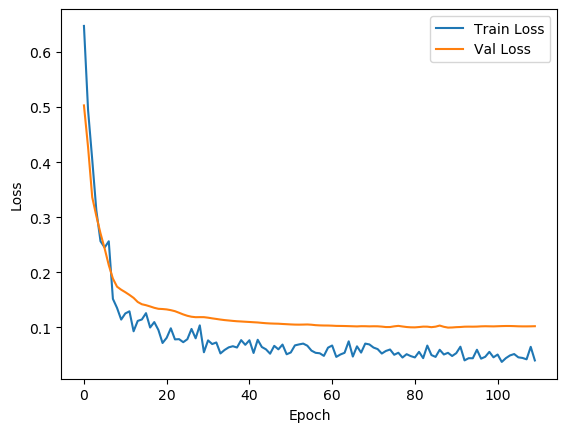

Model saved as: /home/samuele/MLproject/Presentation/AMPM_presentation.ptm


In [18]:
if __name__ == '__main__':
    main()

# Using the model for predictions

In [19]:
import json

In [20]:
def test_model(model, test_loader, criterion, device, feature_count=8):
    model.eval() 
    test_loss = 0.0
    all_y_truth = []
    all_y_pred = []

    with torch.no_grad():  
        for X_batch, y_batch in test_loader:
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            bs, nw, seq_len, feature_dim = X_batch.shape
            X_batch = X_batch.view(bs * nw, seq_len, feature_dim)
            y_batch = y_batch.view(bs * nw, -1)

            y_pred, _ = model(X_batch)

            # Reshape predictions and ground truth to original shape for comparison
            y_pred = y_pred.view(bs, nw, -1)
            y_batch = y_batch.view(bs, nw, -1)

            loss = criterion(y_pred[:, :, :feature_count], y_batch[:, :, :feature_count])
            test_loss += loss.item()

            all_y_truth.append(y_batch[:, :, :feature_count].cpu())
            all_y_pred.append(y_pred[:, :, :feature_count].cpu())

    avg_test_loss = test_loss / len(test_loader)

    # Convert predictions and truth to a format suitable for json
    all_y_truth = torch.cat(all_y_truth, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    print(f"Test Loss: {avg_test_loss:.4f}")
    mae = calculate_metrics(torch.tensor(all_y_pred), torch.tensor(all_y_truth))

    save_results_as_json(all_y_truth, all_y_pred, "/home/samuele/MLproject/Presentation/results.json", mae, avg_test_loss)

In [21]:
def save_results_as_json(truths, predictions, output_path, mae, avg_test_loss):
    results = {
        "Metrics": {
            "Mean Absolute Error (MAE)": round(mae, 4),
            "Average Test Loss": round(avg_test_loss, 4)
        },
        "Predictions": []
    }

    movement_id = 1
    for truth, pred in zip(truths, predictions):
        for t_row, p_row in zip(truth, pred):
            differences = [round(float(t) - float(p), 2) for t, p in zip(t_row.tolist(), p_row.tolist())]
            results["Predictions"].append({
                "Movement": movement_id,
                "Ground Truth": [f"{val:+.2f}" for val in t_row.tolist()],
                "Prediction": [f"{val:+.2f}" for val in p_row.tolist()],
                "Difference": [f"{val:+.2f}" for val in differences]
            })
            movement_id += 1

    with open(output_path, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    print(f"Results saved to {output_path}")

In [22]:
def calculate_metrics(predictions, truths):
    abs_errors = torch.abs(predictions - truths)
    squared_errors = abs_errors ** 2

    mae = abs_errors.mean().item()
    mse = squared_errors.mean().item()

    return mae

In [24]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomLSTM(input_sz=8, hidden_sz=64).to(device)

    model_path = 'AMPM_presentation.ptm'
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

    criterion = nn.MSELoss()

    data_path = 'lstm_dataset6.pt'
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    test_dataset = CustomDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    test_model(model, test_loader, criterion, device, feature_count=8)

In [25]:
if __name__ == '__main__':
    main()

Test Loss: 0.0573
Results saved to /home/samuele/MLproject/Presentation/results.json


# Model evaluation 

In [26]:
# Putting the JSON results file in a pandas DataFrame for easier calculations

# Opening the JSON file
with open('results.json', 'r') as f:
    data = json.load(f)

# Extract the movements
movements = data["Predictions"]

# Names of the columns
columns = ["T_x", "T_y", "T_z", "T_roll", "T_pitch", "T_yaw", "T_lin", "T_ang", 
           "P_x", "P_y", "P_z", "P_roll", "P_pitch", "P_yaw", "P_lin", "P_ang", 
           "D_x", "D_y", "D_z", "D_roll", "D_pitch", "D_yaw", "D_lin", "D_ang"]

# Creating the DataFrame
rows = []
for movement in movements:
    row = movement["Ground Truth"] + movement["Prediction"] + movement["Difference"]
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)
df = df.apply(pd.to_numeric)

## 1. Components of movements that are the best / worst predicted

In [27]:
# Components of the movements
components = ["x", "y", "z", "roll", "pitch", "yaw", "lin", "ang"]

# Creating a DataFrame to show the results in a clear and synthetic way
df_results = pd.DataFrame({
    "Component": components,
    "Sum of Squared Differences": [(df[f"D_{c}"].abs()).sum()  for c in components],
    "Max absolute error": [df[f"D_{c}"].abs().max() for c in components],
    "Relative error": [round((df[f"D_{c}"] / df[f"T_{c}"]).abs()[df[f"T_{c}"] != 0].mean()*100,2) for c in components],
})

# Printing the DataFrame
print(df_results)


  Component  Sum of Squared Differences  Max absolute error  Relative error
0         x                       26.36                0.46           68.10
1         y                       20.37                0.39           24.12
2         z                        4.59                0.12             NaN
3      roll                        5.23                0.06             NaN
4     pitch                        4.64                0.07             NaN
5       yaw                       39.63                2.59           40.55
6       lin                       21.80                0.50            8.84
7       ang                       58.42                3.89          580.49


## 2. Best and worst predicted movements

In [28]:
# Adding, for each movements, the sum of the absolute errors
df["Total_Error"] = df[[f"D_{c}" for c in components]].abs().sum(axis=1)

# Keeping only the 5% best predicted movements (with the smaller total error)
best_predicted = df.nsmallest(int(len(df) * 0.05), "Total_Error")
print(best_predicted[[col for col in df.columns if col.startswith("T_")]])

      T_x   T_y  T_z  T_roll  T_pitch  T_yaw  T_lin  T_ang
186 -1.16 -0.37  0.0     0.0      0.0   0.18   1.08  -0.02
187 -1.20 -0.36  0.0     0.0      0.0   0.18   1.08   0.02
188 -1.24 -0.36  0.0     0.0      0.0   0.18   1.08  -0.01
190 -1.33 -0.36  0.0     0.0      0.0   0.18   1.08  -0.02
191 -1.37 -0.36  0.0     0.0      0.0   0.18   1.08  -0.02
185 -1.12 -0.37  0.0     0.0      0.0   0.18   1.08  -0.02
189 -1.29 -0.36  0.0     0.0      0.0   0.18   1.08  -0.02
43   0.52  0.25  0.0     0.0      0.0  -1.57   0.56  -0.02
42   0.55  0.28  0.0     0.0      0.0  -1.58   0.56  -0.02
41   0.58  0.31  0.0     0.0      0.0  -1.58   0.56  -0.01
44   0.49  0.21  0.0     0.0      0.0  -1.57   0.56  -0.02
40   0.61  0.35  0.0     0.0      0.0  -1.58   0.56   0.00


In [29]:
# Keeping only the 5% worst predicted movements (with the higer total error)
worst_predicted = df.nlargest(int(len(df) * 0.05), "Total_Error")
print(worst_predicted[[col for col in df.columns if col.startswith("T_")]])

      T_x   T_y  T_z  T_roll  T_pitch  T_yaw  T_lin  T_ang
27  -0.04 -1.95  0.0     0.0      0.0   0.42   1.08  -3.54
61  -0.04 -0.37  0.0     0.0      0.0  -1.54   0.56   4.14
31  -0.18 -2.06  0.0     0.0      0.0   2.41   1.08  -0.19
179 -0.87 -0.38  0.0     0.0      0.0   0.18   1.08  -0.06
165 -0.30 -0.33  0.0     0.0      0.0  -0.04   1.08   1.41
168 -0.42 -0.30  0.0     0.0      0.0  -2.38   1.08   0.15
4   -0.02 -0.36  0.0     0.0      0.0   1.03   1.08  -3.39
192 -1.41 -0.36  0.0     0.0      0.0  -2.40   1.08  -0.02
193 -1.45 -0.36  0.0     0.0      0.0  -2.40   1.08  -0.02
160 -0.13 -0.53  0.0     0.0      0.0   0.10   1.08  -0.98
5    0.01 -0.40  0.0     0.0      0.0   0.72   1.08  -1.59
194 -1.49 -0.36  0.0     0.0      0.0  -2.40   1.08  -0.02
